In [498]:
import pandas as pd
import torch
import nltk
device = "cuda" if torch.cuda.is_available() else "cpu"

In [499]:
df = pd.read_csv("/kaggle/input/telegram-spam-or-ham/dataset.csv")
df.head()

,text_type,text
0,spam,naturally irresistible your corporate identity...
1,spam,the stock trading gunslinger fanny is merrill ...
2,spam,unbelievable new homes made easy im wanting to...
3,spam,4 color printing special request additional in...
4,spam,do not have money get software cds from here s...


In [500]:
df = df.rename(columns = {'text_type':'labels','text':'data'})

In [501]:
df.info

<bound method DataFrame.info of       labels                                               data
0       spam  naturally irresistible your corporate identity...
1       spam  the stock trading gunslinger fanny is merrill ...
2       spam  unbelievable new homes made easy im wanting to...
3       spam  4 color printing special request additional in...
4       spam  do not have money get software cds from here s...
...      ...                                                ...
20343    ham                                               /ban
20344    ham                                               /ban
20345    ham                                               /ban
20346    ham                                          Kaisi hii
20347    ham                                            Shock q

[20348 rows x 2 columns]>

In [502]:
df['data'].apply(lambda text: len(text.split())).median()

30.0

In [503]:
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [504]:
stop_words = set(stopwords.words("english"))

In [505]:
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
import torchtext


class MyDataset(Dataset):
    def __init__(self, X, y, max_len=50):
        self.X = X
        self.y = y
        self.max_len = max_len
        
        self.label_encoder = LabelEncoder().fit(y)
        self.vocab = torchtext.vocab.GloVe(name='6B', dim=100)
        #self.vocab = torchtext.vocab.Vectors("/kaggle/input/d/antongalysh/glove6b/glove.6B.50d.txt")

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        label = self.label_encoder.transform([self.y.iloc[idx]])
        label = torch.tensor(label)
        
        text = self.X.iloc[idx]
        tokens = text.split()
        tokens = [word for word in tokens if word.lower() not in stop_words]
        
        if len(tokens) > self.max_len:
            tokens = tokens[:self.max_len]
        else:
            diff = self.max_len - len(tokens)
            
            tokens += ['<pad>'] * diff
        
        X = self.vocab.get_vecs_by_tokens(tokens, lower_case_backup=True)
        
        return X, label[0]
    
    
dataset = MyDataset(df['data'], df['labels'])

In [506]:
from torch.utils.data import random_split

train_ratio = 0.8

# Розділіть набір даних
train_data, test_data = random_split(dataset, [train_ratio, 1-train_ratio])

In [507]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [508]:
from torch import nn
import torch.nn.functional as F
import numpy as np
import math

from torch import Tensor


# Код змінено для batch_first=True

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 50):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    
    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [509]:
class TextClassifier(nn.Module):
    def __init__(self, encoding_dim, max_len, num_classes):
        super().__init__()
        
        self.pos_encoder = PositionalEncoding(d_model=encoding_dim, max_len=max_len)

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=encoding_dim, nhead=5, batch_first=True, dim_feedforward=6200),
            num_layers=1
        )
        # (batch_size, max_len, encoding_dim)

        self.flatten = nn.Flatten()
        # (batch_size, max_len*encoding_dim)

        self.linear1 = nn.Linear(encoding_dim*max_len, encoding_dim*max_len//2)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.linear2 = nn.Linear(encoding_dim*max_len//2, encoding_dim*max_len//4)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.05)
        self.linear3 = nn.Linear(encoding_dim*max_len//4, num_classes)
        
    def forward(self, x):
        out = self.pos_encoder(x)
        out = self.encoder(out)
        out = self.flatten(out)
        out = self.linear1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.linear3(out)
        return out


    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
            y_pred = F.softmax(self.forward(X), dim=-1)

        return y_pred.cpu().numpy()


model = TextClassifier(encoding_dim=100, max_len=50, num_classes=2).to(device)
model

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TextClassifier(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=6200, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=6200, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=5000, out_features=2500, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (linear2): Linear(i

In [510]:
params_num = 0

for param in model.parameters():
    size = param.size()
    
    num = 1
    for item in size:
        num *= item
    params_num += num

params_num

16918352

In [511]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [512]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
              try:
                  history_train[name] += func(y, y_pred) * x.size(0)
              except:
                  if task == 'binary': y_pred_ = y_pred.round()
                  elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                  history_train[name] += func(y, y_pred_) * x.size(0)
                
        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()
        
        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [513]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, test_loader,
                epochs=15,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

train() called: model=TextClassifier, opt=AdamW(lr=0.001000), epochs=15, device=cuda

Epoch    1   14sec	loss:      0.685	val_loss:      0.632	accuracy_score:      0.698	val_accuracy_score:      0.707	
Epoch    2   13sec	loss:      0.394	val_loss:       0.24	accuracy_score:      0.826	val_accuracy_score:      0.886	
Epoch    3   14sec	loss:      0.235	val_loss:      0.218	accuracy_score:      0.903	val_accuracy_score:      0.913	
Epoch    4   14sec	loss:      0.204	val_loss:      0.222	accuracy_score:      0.915	val_accuracy_score:      0.915	
Epoch    5   14sec	loss:      0.181	val_loss:      0.194	accuracy_score:       0.93	val_accuracy_score:      0.926	
Epoch    6   14sec	loss:      0.168	val_loss:       0.19	accuracy_score:      0.934	val_accuracy_score:      0.922	
Epoch    7   13sec	loss:       0.16	val_loss:      0.281	accuracy_score:      0.937	val_accuracy_score:      0.902	
Epoch    8   13sec	loss:       0.15	val_loss:      0.215	accuracy_score:      0.942	val_accuracy_score

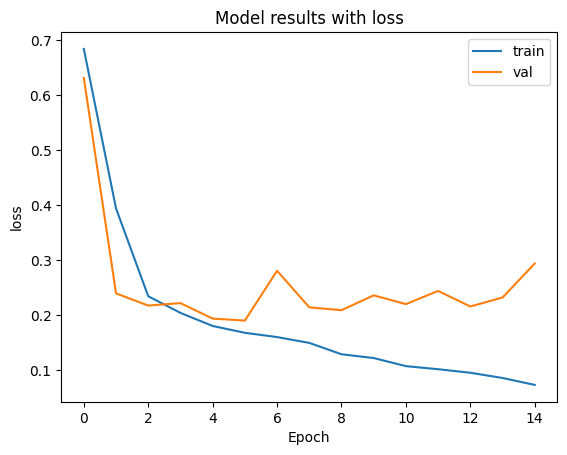

In [514]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

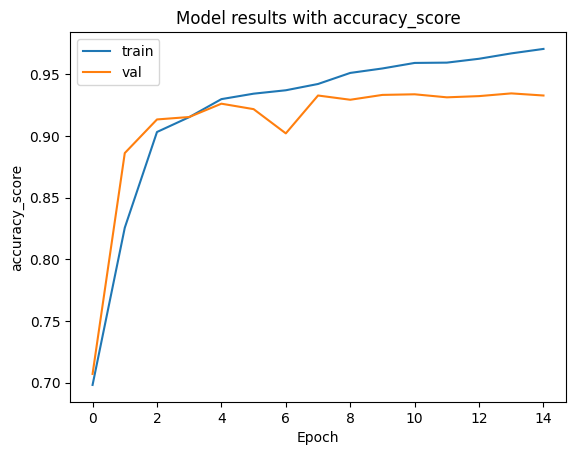

In [515]:
plot_metric(history, 'accuracy_score')

[]

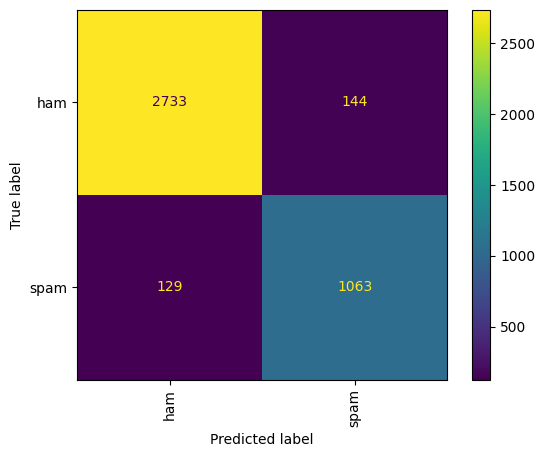

In [516]:
from sklearn.metrics import ConfusionMatrixDisplay

model = model.to('cpu')  # відключаємо від gpu

loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))
X_test, y_test = next(iter(loader))

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.argmax(-1), display_labels=dataset.label_encoder.classes_)
plt.xticks(rotation=90)
plt.plot()

In [517]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred.argmax(-1), target_names=dataset.label_encoder.classes_))

              precision    recall  f1-score   support

         ham       0.95      0.95      0.95      2877
        spam       0.88      0.89      0.89      1192

    accuracy                           0.93      4069
   macro avg       0.92      0.92      0.92      4069
weighted avg       0.93      0.93      0.93      4069

